In [1]:
from boson_data_lib import *
from qutip import *
import numpy as np
import scipy.linalg as sl

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import seaborn as sns

In [2]:
def get_init_states():
    
    init_rho = []
    fidelity_distances = []
    
    #best_init_rho =  np.array([[ 0.96693975+0.j        , -0.17832301+0.00560344j],
    #                           [-0.17832301-0.00560344j,  0.03306025+0.j        ]])
    
    best_init_rho =  np.array([[ 0.0+0.j,  0.0+0.0j],
                               [ 0.0-0.0j, 1.0+0.0j] ]) # exited state
    
    for i in range(0,20):
        gamma = '2.5133'
        directory = "../DATA/"
        
        file = directory + "State_D" + str(i+1) + '_2CUT_data.h5'
        rho, dt = extract_rho(file, gamma)
        
        init_rho.append(rho[1])
        
        fidelity_distances.append(abs(np.trace(sl.sqrtm(sl.sqrtm(init_rho[i]) @ best_init_rho @ sl.sqrtm(init_rho[i])))))
        
    return init_rho, fidelity_distances



def bloch_vector(rho):
    rho = np.matrix(rho)
    # Pauli matrices
    sigmas = [ [[0, 1], [1, 0]], [[0, -1j], [ 1j, 0]], [[1, 0],[0, -1]]] 
    # Bloch vector of the 2 x 2 density matrix
    bloch_vector = np.array([ np.real(np.trace(np.array(sigma) @ rho)) for sigma in sigmas])
    return bloch_vector

def bloch_init_states(rho, fid_distances, view = [-60,30], palette = 'plasma'):
   
    val = np.array(fid_distances) 
    val -= val.min()
    val /= val.max()
    
    colors = plt.cm.get_cmap(palette)(val)[:,:3]

    b = qutip.Bloch()
    b.view = view
    b.point_marker = ['.']
    b.point_size = [300]
    
    b.point_color = colors
    
    for i in range(20):
        xp, yp, zp = bloch_vector(rho[i]).tolist()
        b.add_points([xp, yp, zp])
    
    b.render()
    
    return b

init_rhos, fid_distances  = get_init_states()

In [3]:
def add_log_infidelities(df):

    df['Infidelity_DMD'] = 1 - df.Fidelity_DMD
    df['Infidelity_ERA'] = 1 - df.Fidelity_ERA

    df['LogInF_DMD'] = np.log10(np.abs(df['Infidelity_DMD']))
    df['LogInF_ERA'] = np.log10(np.abs(df['Infidelity_ERA']))

    df.loc[df["LogInF_DMD"] < -15, "LogInF_DMD"] = -15
    df.loc[df["LogInF_ERA"] < -15, "LogInF_ERA"] = -15

    #df['Gamma'] = df['Gamma'].astype(float)
    
    return df  

In [4]:
df = pd.read_pickle('../TESTS/dataframe_DMDvsERA_SB_trn4_tst20_2023-Sep-19_at_11-07.pkl')
df = add_log_infidelities(df)
df4 = df[df.Rank == "4"]
df4

/home/zah/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zah/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Rank,Gamma,State,Distance,Time,gt,Fidelity_DMD,Infidelity_DMD,Fidelity_ERA,Infidelity_ERA,LogInF_DMD,LogInF_ERA
0,4,0.079477,State_D1,0.882992,0.06000,0.004769,1.000000,-2.731149e-14,1.000000,4.440892e-15,-13.563655,-14.352530
1,4,0.079477,State_D1,0.882992,0.08000,0.006358,1.000000,1.442414e-07,1.000000,1.434762e-07,-6.840910,-6.843220
2,4,0.079477,State_D1,0.882992,0.10000,0.007948,1.000000,3.071692e-08,1.000000,2.801455e-08,-7.512622,-7.552616
3,4,0.079477,State_D1,0.882992,0.12000,0.009537,0.999999,8.469971e-07,0.999999,8.136076e-07,-6.072118,-6.089585
4,4,0.079477,State_D1,0.882992,0.14000,0.011127,0.999997,3.056808e-06,0.999997,2.953368e-06,-5.514732,-5.529682
...,...,...,...,...,...,...,...,...,...,...,...,...
745,4,79.477,State_D20,0.967918,0.23650,18.796311,0.999964,3.633905e-05,0.999961,3.872889e-05,-4.439626,-4.411965
746,4,79.477,State_D20,0.967918,0.23675,18.816180,0.999964,3.646550e-05,0.999963,3.697740e-05,-4.438118,-4.432064
747,4,79.477,State_D20,0.967918,0.23700,18.836049,0.999963,3.656975e-05,0.999965,3.530581e-05,-4.436878,-4.452154
748,4,79.477,State_D20,0.967918,0.23725,18.855918,0.999963,3.665051e-05,0.999966,3.371963e-05,-4.435920,-4.472117


In [5]:
def infid_evolve_1_4(df, palette):

    gammas = ['0.079477', '0.25133', '0.79477', '2.5133', '7.9477', '25.133', '79.477', '251.33']
    
    fig, ax = plt.subplots(4, 2, figsize=(8,10)) # sharey=True) #sharex=True,
    
    ax[0,0].set_title('DMD (rank 4)')
    ax[0,1].set_title("ERA (rank 4)")


    for i in range(4):

        ymin = -10
        ymax = -2.75
            
        ytick_range = np.arange(ymin+1, ymax, 3)
        ytick_labels = [r'$10^{-9}$', r'$10^{-6}$', r'$10^{-3}$']

        ax[i,0].yaxis.set_ticks(ytick_range, ytick_labels)
        ax[i,0].yaxis.set_ticks([np.log10(x) for p in ytick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        ax[i,0].set_ylim(ymin, ymax)

        ax[i,1].yaxis.set_ticks(ytick_range, ytick_labels) #["",""])
        ax[i,1].yaxis.set_ticks([np.log10(x) for p in ytick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        ax[i,1].set_ylim(ymin, ymax)
        

        sns.lineplot(
        ax=ax[i,0],
        data=df[(df['Gamma']==gammas[i])],
        x="gt", y="LogInF_DMD",
        hue="Distance",
        palette=palette,
        legend=False,
        alpha=0.5
        )

        ax[i,0].set_xlabel("")
        ax[i,0].set_ylabel(r'$\gamma=$'+gammas[i]+'\n'+r'Infidelity,  $(1-F)$')
        #ax[i].set(yscale="log")

        sns.lineplot(
        ax=ax[i,1],
        data=df[(df['Gamma']==gammas[i])],
        x="gt", y="LogInF_ERA",
        hue="Distance",
        palette=palette,
        legend=False,
        alpha=0.5
        )

        ax[i,1].set_xlabel("")
        ax[i,1].set_ylabel("")
    
    ax[3,0].set_xlabel(r'Time in $\gamma^{-1}$ units')    
    ax[3,1].set_xlabel(r'Time in $\gamma^{-1}$ units')

    return fig

def infid_evolve_5_8(df, palette):

    gammas = ['0.079477', '0.25133', '0.79477', '2.5133', '7.9477', '25.133', '79.477', '251.33']
    
    fig, ax = plt.subplots(4, 2, figsize=(8,10)) # sharey=True) #sharex=True,
    
    ax[0,0].set_title('DMD (rank 4)')
    ax[0,1].set_title("ERA (rank 4)")


    for i in range(4,6):

        ymin = -10
        ymax = -2.75
            
        ytick_range = np.arange(ymin+1, ymax, 3)
        ytick_labels = [r'$10^{-9}$', r'$10^{-6}$', r'$10^{-3}$']

        ax[i-4,0].yaxis.set_ticks(ytick_range, ytick_labels)
        ax[i-4,0].yaxis.set_ticks([np.log10(x) for p in ytick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        ax[i-4,0].set_ylim(ymin, ymax)

        ax[i-4,1].yaxis.set_ticks(ytick_range, ytick_labels) #["",""])
        ax[i-4,1].yaxis.set_ticks([np.log10(x) for p in ytick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        ax[i-4,1].set_ylim(ymin, ymax)
        

        sns.lineplot(
        ax=ax[i-4,0],
        data=df[(df['Gamma']==gammas[i])],
        x="gt", y="LogInF_DMD",
        hue="Distance",
        palette=palette,
        legend=False,
        alpha=0.5
        )

        ax[i-4,0].set_xlabel("")
        ax[i-4,0].set_ylabel(r'$\gamma=$'+gammas[i]+'\n'+r'Infidelity,  $(1-F)$')
        #ax[i].set(yscale="log")

        sns.lineplot(
        ax=ax[i-4,1],
        data=df[(df['Gamma']==gammas[i])],
        x="gt", y="LogInF_ERA",
        hue="Distance",
        palette=palette,
        legend=False,
        alpha=0.5
        )

        ax[i-4,1].set_xlabel("")
        ax[i-4,1].set_ylabel("")

    for i in range(6,8):

        ymin = -10
        ymax = -2.75
            
        ytick_range = np.arange(ymin+1, ymax, 3)
        ytick_labels = [r'$10^{-9}$', r'$10^{-6}$', r'$10^{-3}$']

        ax[i-4,0].yaxis.set_ticks(ytick_range, ytick_labels)
        ax[i-4,0].yaxis.set_ticks([np.log10(x) for p in ytick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        ax[i-4,0].set_ylim(ymin, ymax)

        ax[i-4,1].yaxis.set_ticks(ytick_range, ytick_labels) #["","",""])
        ax[i-4,1].yaxis.set_ticks([np.log10(x) for p in ytick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        ax[i-4,1].set_ylim(ymin, ymax)
        
        sns.lineplot(
        ax=ax[i-4,0],
        data=df[(df['Gamma']==gammas[i])],
        x="gt", y="LogInF_DMD",
        hue="Distance",
        palette=palette,
        legend=False,
        alpha=0.5
        )

        ax[i-4,0].set_xlabel("")
        ax[i-4,0].set_ylabel(r'$\gamma=$'+gammas[i]+'\n'+r'Infidelity,  $(1-F)$')
        #ax[i].set(yscale="log")

        sns.lineplot(
        ax=ax[i-4,1],
        data=df[(df['Gamma']==gammas[i])],
        x="gt", y="LogInF_ERA",
        hue="Distance",
        palette=palette,
        legend=False,
        alpha=0.5
        )

        ax[i-4,1].set_xlabel("")
        ax[i-4,1].set_ylabel("")
    
    ax[3,0].set_xlabel(r'Time in $\gamma^{-1}$ units')    
    ax[3,1].set_xlabel(r'Time in $\gamma^{-1}$ units')

    return fig

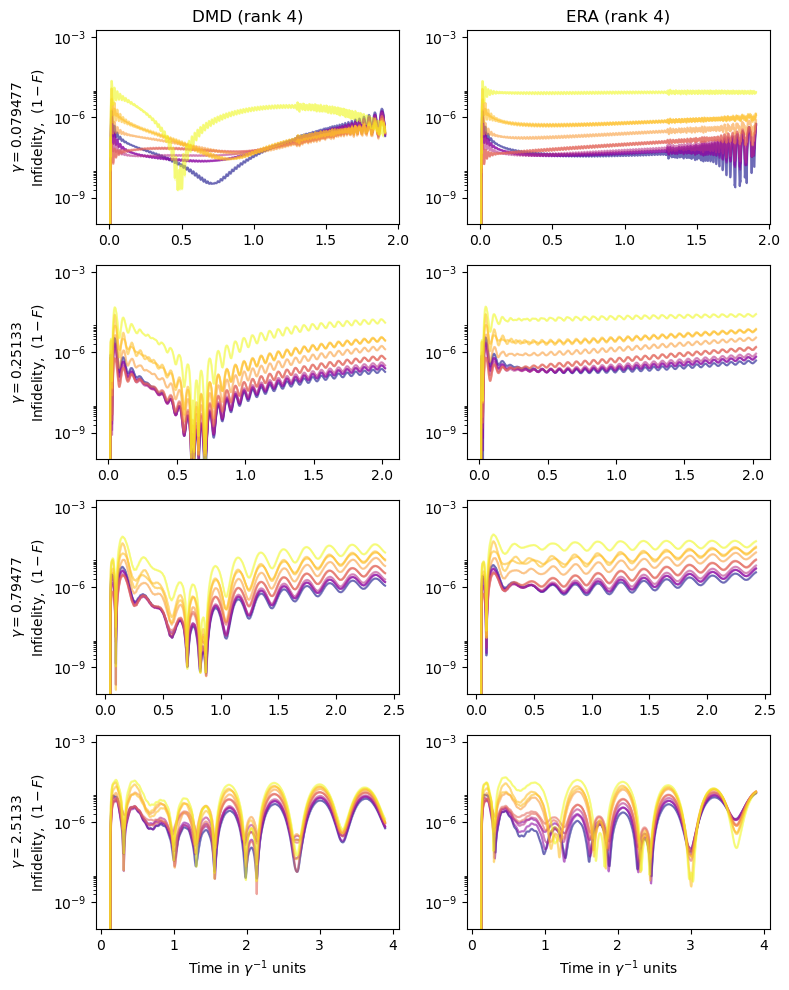

In [6]:
fig1 = infid_evolve_1_4(df4, palette="plasma")
fig1.tight_layout()
fig1.savefig("DMDvsERA_rank-4_SB_4-20_InFid_EVOLVE_1.pdf")

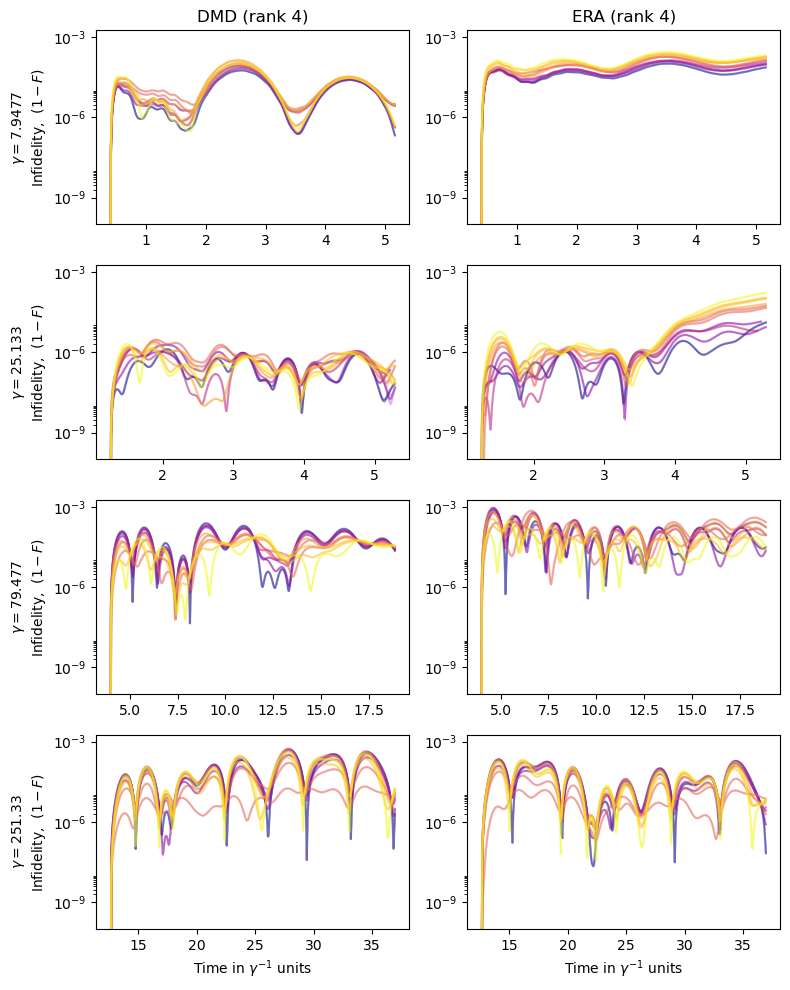

In [7]:
fig2 = infid_evolve_5_8(df4, palette="plasma")
fig2.tight_layout()
fig2.savefig("DMDvsERA_rank-4_SB_4-20_InFid_EVOLVE_2.pdf")